In [1]:
%pylab inline
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

import sys
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
save_path = 'cache/models'

In [3]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())
print(train_dataset.data.size())
print(test_dataset.data.size())

p = train_dataset.data.size()[1]
num_cls = len(set(train_dataset.targets.numpy()))
print(p, num_cls)

batch_size = 100
n_iters = 10000
num_epochs = int(n_iters / (len(train_dataset) / batch_size))+1
print('number of epochs: {}'.format(num_epochs))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
28 10
number of epochs: 17


In [4]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='tanh')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        # One time step
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

input_dim = 28
hidden_dim = 100
layer_dim = 2  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
model.to(device)

# JUST PRINTING MODEL & PARAMETERS 
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

RNNModel(
  (rnn): RNN(28, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)
10
torch.Size([100, 28])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        out, hn = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

In [18]:
### Model Training
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# Number of steps to unroll
seq_dim = 28  

iter = 0
best_acc = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        # Load images as tensors with gradient accumulation abilities
        images, labels = images.view(-1, seq_dim, 
                                     input_dim).requires_grad_().to(device), labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            with torch.no_grad():
                # Iterate through test dataset
                for images, labels in test_loader:
                    # Resize images
                    images = images.view(-1, seq_dim, input_dim).to(device)

                    # Forward pass only to get logits/output
                    outputs = model(images)

                    # Get predictions from the maximum value
                    _, predicted = torch.max(outputs.data, 1)

                    # Total number of labels
                    total += labels.size(0)

                    # Total correct predictions
                    if cuda:
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

            accuracy = 100 * correct.float() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            if accuracy > best_acc:
                best_acc = accuracy
                torch.save({'epoch': epoch,
                            'model': model.state_dict(),
                            'optimizer': optimizer.state_dict()
                           }, '{}/rnn_iter_{}.pth'.format(save_path, iter))
                print('\r Best model saved.\r')
      

Iteration: 500. Loss: 2.189953327178955. Accuracy: 30.09000015258789
 Best model saved.
Iteration: 1000. Loss: 1.464716911315918. Accuracy: 52.5099983215332
 Best model saved.
Iteration: 1500. Loss: 1.197921872138977. Accuracy: 60.38999938964844
 Best model saved.
Iteration: 2000. Loss: 1.0363229513168335. Accuracy: 68.69000244140625
 Best model saved.
Iteration: 2500. Loss: 0.6255834698677063. Accuracy: 76.91999816894531
 Best model saved.
Iteration: 3000. Loss: 0.5705212950706482. Accuracy: 82.12999725341797
 Best model saved.
Iteration: 3500. Loss: 0.5536036491394043. Accuracy: 86.5999984741211
 Best model saved.
Iteration: 4000. Loss: 0.39299893379211426. Accuracy: 88.87999725341797
 Best model saved.
Iteration: 4500. Loss: 0.2634774148464203. Accuracy: 90.4800033569336
 Best model saved.
Iteration: 5000. Loss: 0.22030633687973022. Accuracy: 92.36000061035156
 Best model saved.
Iteration: 5500. Loss: 0.2439391016960144. Accuracy: 93.6500015258789
 Best model saved.
Iteration: 6000.

In [20]:
### Load and use the best model
bst_mdl = save_path+'/rnn_best.pth'
model.load_state_dict(torch.load(bst_mdl)['model'])

<All keys matched successfully>

In [21]:
images[0].max()

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
### Feeding white-noise
model.eval()

batch_size = 10000
all_size = 1000000
iters = 100
stats = {} # recording the bias
noise = {}

for i in range(num_cls):
    stats[i] = 0
    noise[i] = []

with tqdm(total=iters, file=sys.stdout) as pbar:
    for kk in range(iters):
        z = torch.rand(all_size, p, p)
        for k in range(0, all_size, batch_size):
            with torch.no_grad():
                cur_data = z[k:k+batch_size]
                if cuda:
                    cur_data = cur_data.cuda()
                pred = model(cur_data).max(1)[1]

            for i in range(num_cls):
                noise[i].append(cur_data[pred == i].cpu())
                stats[i] += (pred == i).sum().cpu()
        pbar.update(1)

 21%|██        | 21/100 [02:03<08:17,  6.30s/it]

In [23]:
# acc = 96.36000061035156
stats

{0: tensor(1060840),
 1: tensor(0),
 2: tensor(617),
 3: tensor(9562),
 4: tensor(0),
 5: tensor(0),
 6: tensor(0),
 7: tensor(2),
 8: tensor(8622748),
 9: tensor(306231)}

0


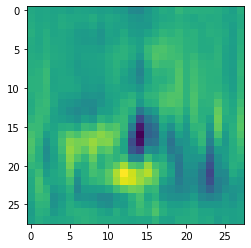

2


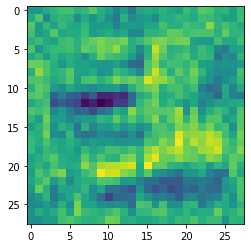

3


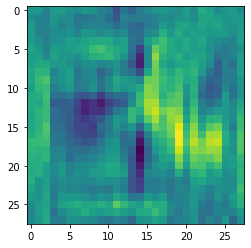

7


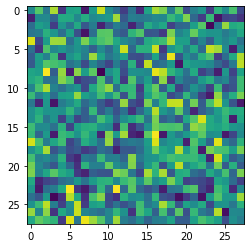

8


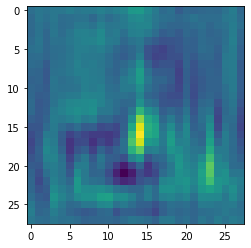

9


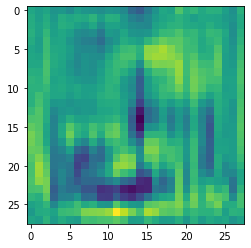

In [24]:
# visualize
for i in range(num_cls):
    if stats[i] != 0:
        print(i)
        plt.imshow(torch.cat(noise[i]).mean(0))
        plt.show()